In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from value_iteration.models import ValueIterationNetwork, GridWorldNode
from value_iteration.models import MCTS, GridWorldNode, MctsSr



from value_iteration.models.utils import softmax
from value_iteration.models.sr import get_optimal_sr_from_transitions
from value_iteration.environments.thread_the_needle import make_thread_the_needle, make_thread_the_needle_walls_moved_door
from value_iteration.environments.thread_the_needle import find_sortest_path_length, find_shortest_path

import value_iteration.environments.thread_the_needle as e



## MCTS simulations
These simulations are meant to show that the diffusion policy (a proxy for the stochastic simulation step) are not great for directed search. 

Text(0.5, 1.0, 'diffusion state-value function')

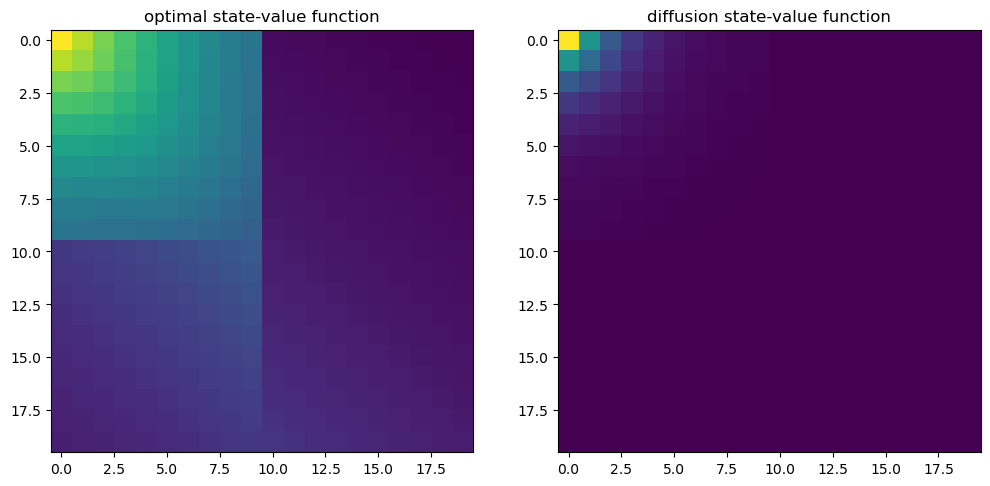

In [2]:
# define the enviornment
n_rows, n_columns = 20, 20
gamma = 0.95
sr_kwargs = dict(n_rows=n_rows, n_columns=n_columns, gamma=gamma)


transition_functions, reward_functions, optimal_policy = e.make_thread_the_needle(
    n_rows=n_rows,
    n_columns=n_columns,
    movement_penalty=0.1,
    slip_probability=0.001,
    random_movement_on_error=True,
    sparse=False,
)
M = get_optimal_sr_from_transitions(transition_functions, optimal_policy, gamma=gamma)


transition_functions_diffusion = [
    np.mean(transition_functions, axis=0) for _ in range(4)
]

M_diff = get_optimal_sr_from_transitions(
    transition_functions_diffusion, optimal_policy, gamma=gamma
)


v_optimal = M.dot(reward_functions)
v_diffus = M_diff.dot(reward_functions)


fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(v_optimal.reshape(n_rows, n_columns))
axes[0].set_title("optimal state-value function")
axes[1].imshow(v_diffus.reshape(n_rows, n_columns))
axes[1].set_title("diffusion state-value function")

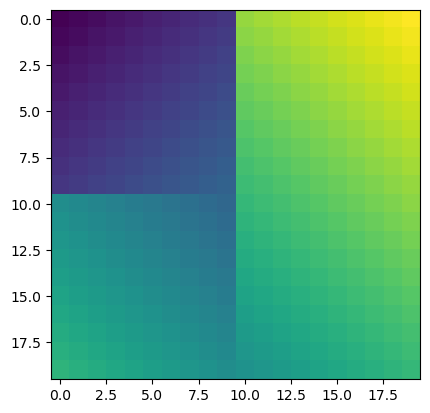

In [3]:
#
f = lambda s: find_sortest_path_length(
    v_optimal, transition_functions, 0, s, n_rows, n_columns
)
distances_to_goal = np.array([f(s) for s in range(n_rows * n_columns)])
plt.imshow(distances_to_goal.reshape(n_rows, n_columns))

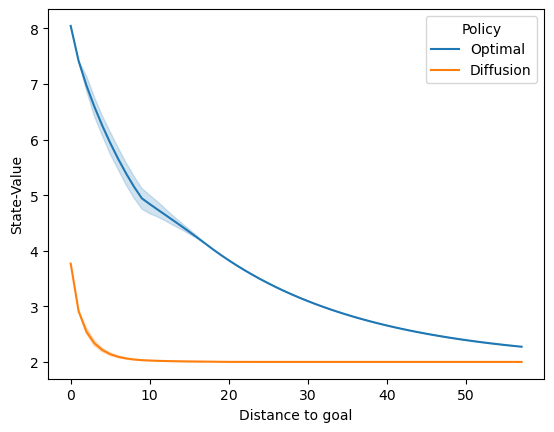

In [4]:
df = pd.DataFrame(
    {
        "Distance to goal": np.concatenate([distances_to_goal] * 2),
        "State-Value": np.concatenate([v_optimal, v_diffus]),
        "Policy": ["Optimal"] * (n_rows * n_columns)
        + ["Diffusion"] * (n_rows * n_columns),
    }
)
sns.lineplot(x="Distance to goal", y="State-Value", hue="Policy", data=df)
plt.savefig("images/heurisitic_function_againt_distance_to_goal.png", dpi=300)

In [5]:
df.groupby(
    [
        "Distance to goal",
    ]
)

<Axes: xlabel='Distance to goal', ylabel='State-Value Gradient'>

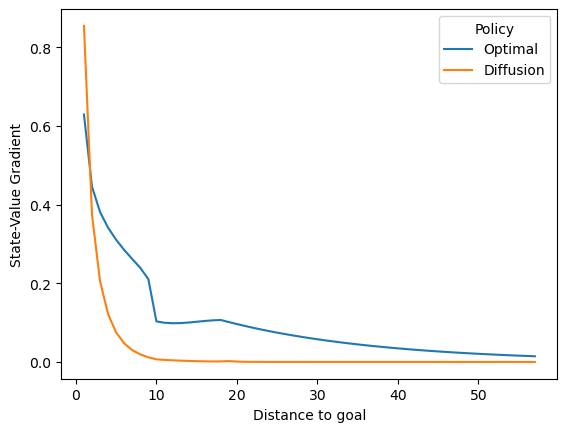

In [6]:
def get_grad(vec: np.ndarray) -> np.ndarray:
    return vec[:-1] - vec[1:]


df2 = pd.DataFrame(
    {
        "Distance to goal": np.concatenate(
            [
                df.groupby(
                    [
                        "Policy",
                        "Distance to goal",
                    ]
                )
                .mean()
                .loc["Optimal"]
                .index[1:]
            ]
            * 2
        ),
        "State-Value Gradient": np.concatenate(
            [
                get_grad(
                    df.groupby(
                        [
                            "Policy",
                            "Distance to goal",
                        ]
                    )
                    .mean()
                    .loc["Optimal"]
                    .values
                ),
                get_grad(
                    df.groupby(
                        [
                            "Policy",
                            "Distance to goal",
                        ]
                    )
                    .mean()
                    .loc["Diffusion"]
                    .values
                ),
            ]
        ).reshape(-1),
        "Policy": ["Optimal"] * (df["Distance to goal"].max())
        + ["Diffusion"] * (df["Distance to goal"].max()),
    }
)

sns.lineplot(x="Distance to goal", y="State-Value Gradient", hue="Policy", data=df2)

# MCTS 2: Variance of the simulation
How bad is the estimate of the value function?  If we simulate a random agent starting at each state and letting them run for 10k steps, what is their value estimate? If we repeate this procedure k times, we can get a varance of the value function and show that it's difficult to estimate to any precision.  This would mean the simulation step isn't helpful


In [7]:
goals_state = 0

mcts_kwargs = dict(
    end_states=[goals_state],
    transition_functions=transition_functions,
    state_reward_function=reward_functions,
    exploration_weight=2**0.5,
    max_depth=500,
    n_sims=5,
    gamma=gamma,
)
mcts = MCTS(**mcts_kwargs)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:07<00:00, 52.91it/s]


<Axes: xlabel='Distance to Goal', ylabel='State-Value'>

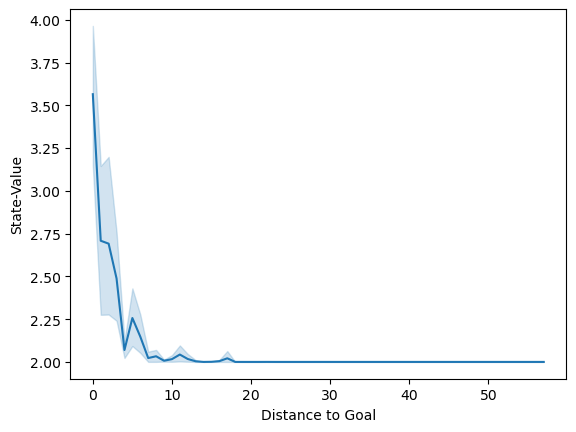

In [8]:
df = []
for s in tqdm(range(0, n_columns * n_rows)):
    d = distances_to_goal[s]
    sim_state_values = mcts.simulate_state_value(GridWorldNode(s, n_actions=4))

    for v in sim_state_values:
        df.append({"Distance to Goal": d, "State-Value": v, "Model": "Simulation"})
sns.lineplot(x="Distance to Goal", y="State-Value", data=pd.DataFrame(df))

# Run MCTS with different heuristic functions

In [9]:
gamma = 0.99
state_action_reward_functions = e.get_state_action_reward_from_sucessor_rewards(
    reward_functions, transition_functions
)

kwargs = dict(
    transition_functions=transition_functions,
    reward_functions=state_action_reward_functions,
    n_rows=n_rows,
    n_columns=n_columns,
    gamma=gamma,
    iterations=1000,
    initialization_noise=0.01,
    return_interim_estimates=False,
)

Q, V = ValueIterationNetwork.value_iteration(**kwargs)

  0%|          | 0/1000 [00:00<?, ?it/s]

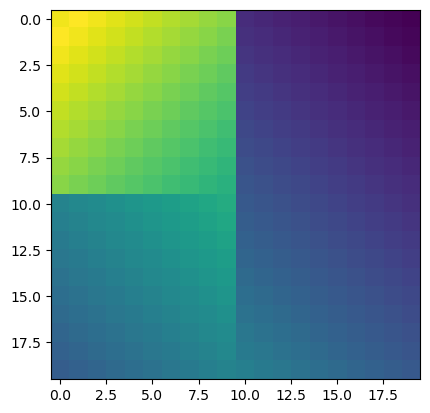

In [10]:
plt.imshow(V.reshape(20, 20))

In [11]:
goal_state = 0
start_state = (
    n_rows * n_columns - n_columns // 2 + n_columns // 4 - n_columns * (n_rows // 4)
)
start_node = GridWorldNode(start_state, n_actions=4)

n_batches = 25
beta = 5.0
n_rollout = 500

mcts_kwargs = dict(
    end_states=[goals_state],
    transition_functions=transition_functions,
    state_reward_function=reward_functions,
    exploration_weight=2**0.5 * 0.05,
    max_depth=500,
    n_sims=100,
    gamma=gamma,
)

batch_rollout_kwargs = dict(
    start_node=start_node,
    n_batches=n_batches,
    n_rollouts=n_rollout,
    beta=beta,
)

In [12]:
mcts_sr = MctsSr(**mcts_kwargs)
mcts_sr_selection_pmf, mcts_sr_visitations = mcts_sr.batch_rollouts(
    **batch_rollout_kwargs
)

Batch: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [01:00<00:00,  2.42s/it]


In [ ]:
# Value function as heuristic
mcts_vi = MctsSr(**mcts_kwargs)
mcts_vi.update_heuristic_function(V)

mcts_vi_selection_pmf, mcts_vi_visitations = mcts_vi.batch_rollouts(
    **batch_rollout_kwargs
)

Batch:  72%|██████████████████████████████████████████████████████████████████████████████████████▍                                 | 18/25 [00:31<00:12,  1.75s/it]

In [ ]:
pi_star = e.make_thread_the_needle_optimal_policy(n_rows, n_columns)

beta = 1.0


def scoring_function(p, q):
    # how much weight is put on a correct action?
    return p.dot(q)


score_sr = [scoring_function(p, q) for p, q in zip(pi_star, mcts_sr_selection_pmf)]
score_vi = [scoring_function(p, q) for p, q in zip(pi_star, mcts_vi_selection_pmf)]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax = axes[0]
neg = ax.imshow(np.reshape(score_sr, (n_rows, n_columns)), cmap="viridis")
e.clean_up_thread_the_needle_plot(ax, n_columns, n_rows)

ax = axes[1]
neg = ax.imshow(np.reshape(score_vi, (n_rows, n_columns)), cmap="viridis")
e.clean_up_thread_the_needle_plot(ax, n_columns, n_rows)

# ax = axes[2]
# plt.colorbar(neg, ax=ax, label='Similarity')

In [ ]:
neg = plt.imshow(np.reshape(score_sr, (n_rows, n_columns)), cmap="viridis")
e.clean_up_thread_the_needle_plot(plt.gca(), n_columns, n_rows)
plt.colorbar(label="Policy Error")
plt.title("Policy Error:\nMCTS w/ default heuristic")
plt.savefig("images/mcts_policy_error.png", dpi=300)

# ax = axes[1]
# neg = ax.imshow(np.reshape(score_vi, (n_rows, n_columns)), cmap='viridis')
# e.clean_up_thread_the_needle_plot(ax, n_columns, n_rows)

In [ ]:
neg = plt.imshow(np.reshape(score_vi, (n_rows, n_columns)), cmap="viridis")
e.clean_up_thread_the_needle_plot(plt.gca(), n_columns, n_rows)
plt.colorbar(label="Policy Error")
plt.title("Policy Error:\nMCTS w/ True Value Function")
plt.savefig("images/mcts_policy_error_true_value.png", dpi=300)

In [ ]:
plt.imshow(mcts_vi_selection_pmf[:, 0].reshape((n_rows, n_columns)))
e.clean_up_thread_the_needle_plot(plt.gca(), n_columns, n_rows)

In [ ]:
plt.imshow(mcts_vi_visitations.reshape(20, 20), cmap="magma_r")
e.clean_up_thread_the_needle_plot(plt.gca(), n_rows, n_columns)
plt.colorbar(label="Probability of Expansion")
plt.title("Expanded States:\nMCTS w/ True Value Function")
plt.savefig("images/mcts_expanded_states_true_value.png", dpi=300)

In [ ]:
plt.imshow(mcts_sr_visitations.reshape(20, 20), cmap="magma_r")
e.clean_up_thread_the_needle_plot(plt.gca(), n_rows, n_columns)
plt.colorbar(label="Probability of Expansion")
plt.title("Expanded States:\nMCTS w/ default heuristic")
plt.savefig("images/mcts_expanded_states.png", dpi=300)

## Plot:
show 2x4 plot with the top row be MCTS using random drift, the bottom row using the true value function
each columns shows a probability map of expanding states, increasing in log scale (e.g. 10 rollouts, 100 rollouts, 1000 rollouts) or similar